---
# **Introduction**

*   *Start with download and analysing data.*
*   *Generate different datasets with different stride and padding for each category (all combination of stride and padding).*
*   *Create different models from scratch playing with LSTM (good for long---term timeseries) and Conv1D (good for short---term timeseries) layers and with training parameters and doing the first experiments.*
*   *Research of new layers: Attention for repetitive patterns and seasonality; ResNet with Conv1D and ResNet with LSTM to test the results with the residual method.*
*   *Doing this loop of train and test to detect the best model setup.*
*   *Start to think about a single model without dividing into categories. -> Do new train and test with this new approach.*
*   **During all training phases, analyze the results of MSE and MAE to understand which parameters to modify for subsequent trains.**

---
# 🌐 **GLOBAL VARIABLES** 🌐
*   *Source variables of files and directories*
*   *Fix randomness*
*   *Data management*
*   *Model parameters*
*   *Training parameters*

In [ ]:
# Source variables --- DON'T CHANGE THEM ! -------------------------------------------------------------
data_training_name = 'training_data.npy'                            # Timeseries Dataset
data_valid_name = 'valid_periods.npy'                               # Valid Period of each timeseries in the dataset
data_categories_name = 'categories.npy'                             # Categories of each timeseries in the dataset
in_dim = 200 # WINDOW                                               # Window of the data
out_dim = 18 # TELESCOPE                                            # Telescope of the data
data_stride = [10, 25, 50, 75, 100, 150, 200]                       # Data stride
data_max_pad_perc = [.0, .25, .50, .75]                             # data_max_pad_perc % * in_dim
categories = ['A', 'B', 'C', 'D', 'E', 'F']                         # Categories available
data_clean_name = {                                                 # Name of data clean file
  'A': 'data_clean_sxx_pxx_a.npz',
  'B': 'data_clean_sxx_pxx_b.npz',
  'C': 'data_clean_sxx_pxx_c.npz',
  'D': 'data_clean_sxx_pxx_d.npz',
  'E': 'data_clean_sxx_pxx_e.npz',
  'F': 'data_clean_sxx_pxx_f.npz'
}
modsub_dir = 'MOD_SUB/'                                             # Directory of all models & submissions
data_dir = 'DATA/'                                                  # Directory of all data
# ------------------------------------------------------------------------------------------------------

# CodaLab Test Out Dim
test_out_dim = 18                                                   # Dimension of output on codalab test

# Fix randomness
seed = 42

# Data parameters
data_process_phase = False                                          # True : execute the data process code , False : no
file_stride = '75'                                                  # Stride of data file
file_padding = '50'                                                 # Padding of data file
file_category = 'c'                                                 # Category of data file
val_size = 0.1                                                      # Validation size

# Training parameters
train_phase = True                                                  # True = Train is active     False = Train is NOT active
val_size = 0.1                                                      # Validation size
batch_size = 64                                                     # Batch size
epochs = 400                                                        # Max training epochs
learning_rate = 0.001                                               # Adam Optimizer -> default learning rate = 0.001
earlystopping_patience = 120                                        # Early Stopping patience (only if earlystopping = True)
plateaustopping_patience = 100                                      # Plateau Stopping

# Model parameters
model_name_load = [                                                 # if model_name_load == [] -> Create Model for EACH categories, else -> Merge Models
  """
  "m67_a_s50_p0",
  "m107_b_s75_p50",
  "m38_c_s75_p50",
  "m135_d_s25_p50",
  "m137_e_s10_p50",
  "m71_f_s10_p75"
  """
]
model_one = False                                                   # if model_one = True -> Create Model for ALL categories, else -> No

"""
layer = [
    {"type": "dense", "units": 32, "activation": "relu"},
    {"type": "conv1d", "filters": 32, "kernel": 3, "activation": "relu"},
    {"type": "conv2d", "filters": 32, "kernel": (3,3), "activation": "relu"},
    {"type": "maxp", "kernel": (3,3)},
    {"type": "gap"},
    {"type": "flat"},
    {"type": "dropout", "rate": 0.2},
    {"type": "lstm", "units": 32, "bidirectional": True, "return_sequences": True},
    {"type": "resblock", "filters": 128, "kernel": 3, "units": 3, "activation": "relu"},
    {"type": "resblock_lstm", "lstm_units": 32, "units": 3, "activation": "relu", "bidirectional": True},
    {"type": "crop1d", "outsize": 18},
    {"type": "attention"},
    {"type": "xception"},
    {"type": "efficientnetb4"},
    {"type": "efficientnetv2s"},
]
"""

#
layer=[
    {"type": "lstm", "units": 96, "bidirectional": True, "return_sequences": True},
    {"type": "conv1d", "filters": 128, "kernel": 3, "activation": "relu"},
    {"type": "conv1d", "filters": 128, "kernel": 3, "activation": "relu"}
]

---
# 📍 **GOOGLE DRIVE LINK** 📍


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/EB_Squared [AN2DL]

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1M4nRWAD8y03Ru5g-wMbN1s3CvHD-jQBZ/EB_Squared [AN2DL]


---
# 📚 **LIBRARIES & INIT** 📚

*   **\"[os](https://docs.python.org/3/library/os.html)"** *: Create directories.*
*   **\"[random](https://docs.python.org/3/library/random.html)"** *: Fix randomness.*
*   **\"[numpy](https://numpy.org/)"** *: More efficient array management.*
*   **\"[matplotlib](https://matplotlib.org/)"** *: Plot graphs ecc...*
*   **\"[sklearn](https://scikit-learn.org/stable/)"** *: To split dataset in train data and test data.*
*   **\"[tensorflow](https://www.tensorflow.org/)"+"[keras](https://www.tensorflow.org/guide/keras)"** *: Tensor porpouse (More efficient array as NumPy). Create and manage the AI Model. Create and manage layers in the AI Model*

In [ ]:
# Libraries
import os                                                           # Import Os Library as "os"                                                               : Create directories
import random                                                       # Import Random Library as "random"                                                       : Fix randomness
import numpy as np                                                  # Import NumPy Library as "np"                                                            : More efficient array management
import matplotlib.pyplot as plt                                     # Import Pyplot Library from Matplotlib as "plt"                                          : Plot graphs ecc...
import tensorflow as tf                                             # Import Tensorflow Library as "tf"                                                       : Tensor porpouse (More efficient array as NumPy)
from tensorflow import keras as tfk                                 # Import Keras Library from Tensorflow as "tfk"                                           : Create and manage the AI Model
from tensorflow.keras import layers as tfkl                         # Import Layers Library from Keras as "tfkl"                                              : Create and manage layers in the AI Model
from tensorflow.keras import backend as tfkb                        # Import Backend Library from Keras as K                                                  : Used in defining the Attention Layer
from sklearn.model_selection import train_test_split                # Import train_test_split() Function from sklearn.model_selection as "train_test_split"   : To split dataset in train data and test data

# Fix randomness
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Init
plt.rc('font', size=8)                                              # Pyplot set font
#tf.keras.mixed_precision.set_global_policy("mixed_float16")         # Keras mixed precision : Mixed precision training is the use of lower-precision operations (float16 and bfloat16) in a model during training to make it run faster and use less memory.
print("\033[1mTensorflow Version\033[0m:", tf.__version__)          # Tensorflow version

Tensorflow Version: 2.15.0


---
# 🛠️ **DATA PROCESS [PHASE]** 🛠️

## **Raw Data**
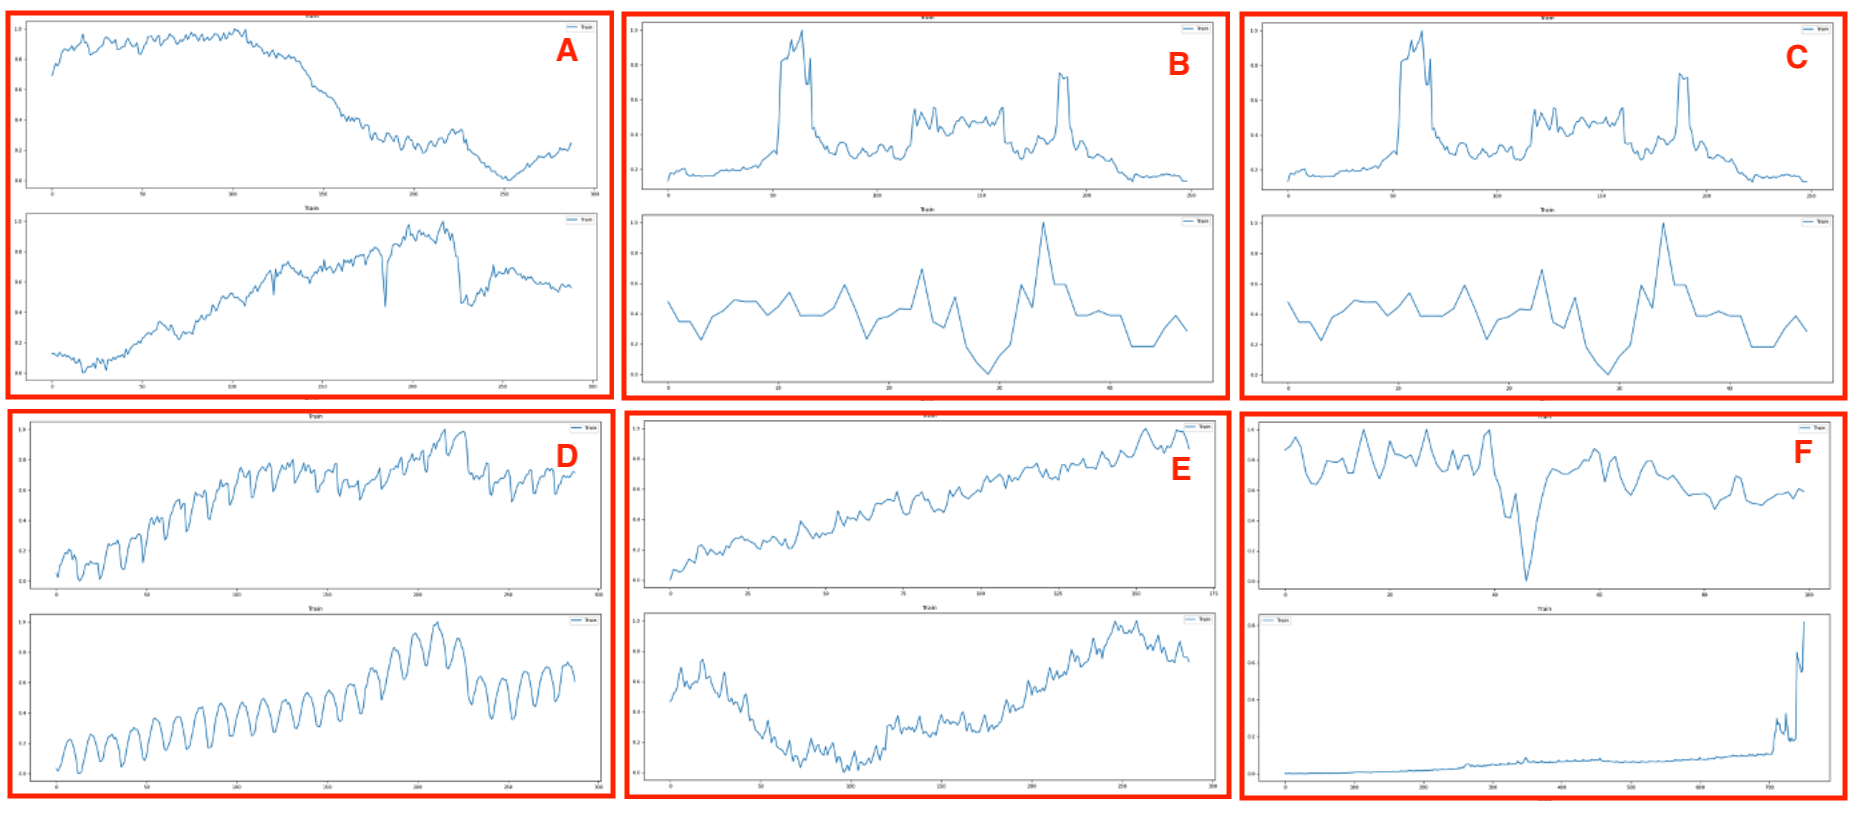



## **Extract 200+18 timeseries**

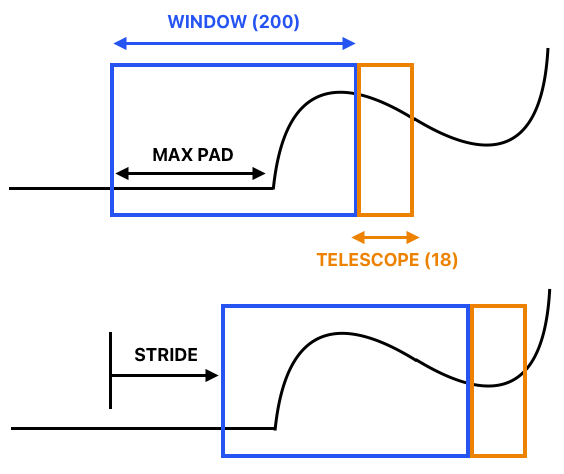

* *Data Load*
* *Data Plot*
* *Data Process (Clean Data): generate all possible combination of stride-padding-category*

**CATEGORY : a, b, c, d, e, f**

**STRIDE : 10, 25, 50, 75, 100, 150, 200**

**PAD % : 0, 25, 50, 75**

**data_clean_sSTRIDE_pPAD_CATEGORY.npz**

"data" : [ [timeseries_0] , [timeseries_1] , ...] @ (BS, 200)

"out" : [ [timeseries_0] , [timeseries_1] , ...] @ (BS, 18)

"pad" : [ 123 , 124 , ...] @ (BS,)

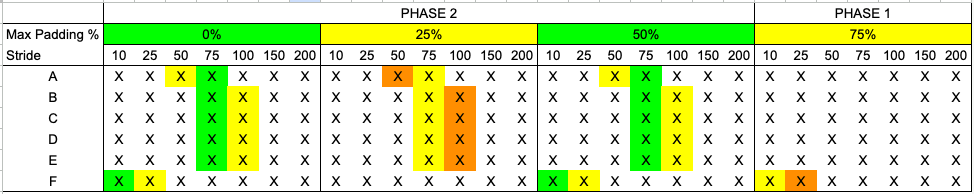---


In [ ]:
if data_process_phase:

  # Load Raw Data
  data_training_load = np.load(data_dir+data_training_name, allow_pickle=True).astype(np.float32)
  data_valid_load = np.load(data_dir+data_valid_name, allow_pickle=True).astype(np.int32)
  data_categories_load = np.load(data_dir+data_categories_name, allow_pickle=True)

  # Inspect Raw Data
  print("\033[1mRow Training Data Shape\033[0m:", data_training_load.shape)
  print("\033[1mRow Valid Period Data Shape\033[0m:", data_valid_load.shape)
  print("\033[1mRow Categories Data Shape\033[0m:", data_categories_load.shape)

  print("\033[1mRow Training Data\033[0m:\n", data_training_load)
  print("\033[1mRow Valid Period Data\033[0m:\n", data_valid_load)
  print("\033[1mRow Categories Data\033[0m:", data_categories_load)
  print("\033[Total Categories\033[0m:", np.unique(data_categories_load))

  # Plot charts ----------------------------------------------------------------
  original = False
  indexes = [0, 1, 2]#, 3000, 4000, 5000, 10000, 15000, 20000, 30000, 40000, 45000]
  for i in indexes:
    plt.figure(figsize=(17,5))
    if original:
      plt.plot(data_training_load[i], label='Train')
    else:
      plt.plot(data_training_load[i][data_valid_load[i][0]:], label='Train')
    plt.title('Train')
    plt.legend()
    plt.show()
  # ----------------------------------------------------------------------------

  def clean(category): # it takes max_pad_perc = 75% and it creates different file with different stride
    # ---------- PHASE 1 - CREATE DATA WITH MAX PADDING 75% AND DIFFERENT STRIDES ----------
    max_pad_perc = data_max_pad_perc[-1] # it means how much max padding we want at the begining of the input series (.75 = 75%*200 -> padding = 150 start zeros in 200 input data)
    max_pad_perc_name = str(int(max_pad_perc*100.0))
    if len(max_pad_perc_name) == 0:
      max_pad_perc_name = "0"
    elif max_pad_perc > 0.0 and len(max_pad_perc_name) == 1:
      max_pad_perc_name = "0"+max_pad_perc_name
    for stride in data_stride: # iterate in all stride with fixed padding
      stride_name = str(stride)
      dim = data_training_load.shape[0]
      in_out_dim = in_dim + out_dim
      max_pad = int(max_pad_perc * in_dim)
      data_clean = np.delete(np.zeros((1, in_dim), dtype=float), 0, axis=0)
      data_out_clean = np.delete(np.zeros((1, out_dim), dtype=float), 0, axis=0)
      data_pad_clean = np.array([])
      for i in range(dim):
        if dim-0.6 > 0.0:
          perc = int((float(i) / float(dim-0.6)) * 100.0)
        else:
          perc = -1
        print("PHASE 1 -", category, ": <pad="+max_pad_perc_name+" stride="+stride_name+">", perc, "%")
        cat = data_categories_load[i]
        if cat == category:
          arr = data_training_load[i]
          arr_start = data_valid_load[i][0]
          arr_end = data_valid_load[i][1]
          range_ = arr_end - arr_start
          if in_out_dim > max_pad + range_:
            pass # if the timeseries is too short, in other words it has more initial padding than the maximum padding that we set (max_pad_perc)
          elif in_out_dim == max_pad + range_: # the dataset is equal to 200+18+ max padding that we want
            pad = max_pad
            data = arr[arr_end-in_out_dim:arr_end-out_dim] # [2776-218 : 2776-18]
            out = arr[arr_end-out_dim:arr_end] # [2776-18 : 2776]
            data_clean = np.append(data_clean, [ data ], axis=0)
            data_out_clean = np.append(data_out_clean, [ out ], axis=0)
            data_pad_clean = np.append(data_pad_clean, pad)
          else: # # the dataset is > to 200+18+ max padding that we want
            remain = max_pad + (range_ - in_out_dim)
            remain -= (remain % stride)
            tot_pad = remain - (range_ - in_out_dim)
            j = 0
            while(j <= remain):
              index_data_start = arr_start - tot_pad + j # included
              index_data_end = index_data_start + in_dim # not included
              index_out_start = index_data_end
              index_out_end = index_out_start + out_dim
              pad = tot_pad - j
              if pad < 0:
                pad = 0
              data = arr[index_data_start:index_data_end] # take 200 step
              out = arr[index_out_start:index_out_end] # take 18 step
              if len(data) == in_dim and len(out) == out_dim:
                data_clean = np.append(data_clean, [ data ], axis=0)
                data_out_clean = np.append(data_out_clean, [ out ], axis=0)
                data_pad_clean = np.append(data_pad_clean, pad)
              j += stride
      # Save data
      np.savez(data_dir+data_clean_name[category].replace('.npz', '').replace('clean_sxx_pxx', 'clean_s'+stride_name+'_p'+max_pad_perc_name), data=data_clean, out=data_out_clean, pad=data_pad_clean)
    # ---------- PHASE 2 - CREATE DATA WITH LESS PADDING < 90% AND DIFFERENT STRIDES ----------
    max_pad_perc_start = data_max_pad_perc[-1] # it means how much max padding we want at the begining of the input series (.35 = 35%*200 -> padding = 70 start zeros in 200 input data)
    max_pad_perc_start_name = str(int(max_pad_perc_start*100.0))
    if len(max_pad_perc_start_name) == 0:
      max_pad_perc_start_name = "0"
    elif max_pad_perc_start > 0.0 and len(max_pad_perc_start_name) == 1:
      max_pad_perc_start_name = "0"+max_pad_perc_start_name
    for stride in data_stride: # iterate in all stride
      stride_name = str(stride)
      data_clean_load = np.load(data_dir+data_clean_name[category].replace('clean_sxx_pxx', 'clean_s'+stride_name+'_p'+max_pad_perc_start_name), allow_pickle=True)
      data = data_clean_load["data"]
      out = data_clean_load["out"]
      pad = data_clean_load["pad"]
      dim = data.shape[0]
      for max_pad_perc in data_max_pad_perc[:-1]: # iterate in all padding without the last (of the phase 1)
        max_pad_perc_name = str(int(max_pad_perc*100.0))
        if len(max_pad_perc_name) == 0:
          max_pad_perc_name = "0"
        elif max_pad_perc > 0.0 and len(max_pad_perc_name) == 1:
          max_pad_perc_name = "0"+max_pad_perc_name
        max_pad = int(max_pad_perc * in_dim)
        data_clean = np.delete(np.zeros((1, in_dim), dtype=float), 0, axis=0)
        data_out_clean = np.delete(np.zeros((1, out_dim), dtype=float), 0, axis=0)
        data_pad_clean = np.array([])
        i = 0
        while i < dim:
          if dim-0.6 > 0.0:
            perc = int((float(i) / float(dim-0.6)) * 100.0)
          else:
            perc = -1
          print("PHASE 2 -", category, ": <pad="+max_pad_perc_name+" stride="+stride_name+">", perc, "%")
          if pad[i] <= max_pad: # i take the timeseries just if the pad is <= max pad that we want
            data_clean = np.append(data_clean, [ data[i] ], axis=0)
            data_out_clean = np.append(data_out_clean, [ out[i] ], axis=0)
            data_pad_clean = np.append(data_pad_clean, pad[i])
          i += 1
        # Save data
        np.savez(data_dir+data_clean_name[category].replace('.npz', '').replace('clean_sxx_pxx', 'clean_s'+stride_name+'_p'+max_pad_perc_name), data=data_clean, out=data_out_clean, pad=data_pad_clean)

  # Generate all the datasets for each category
  for category in categories:
    clean(category)

---
# 🥪 **DATA LOAD** 🥪

\

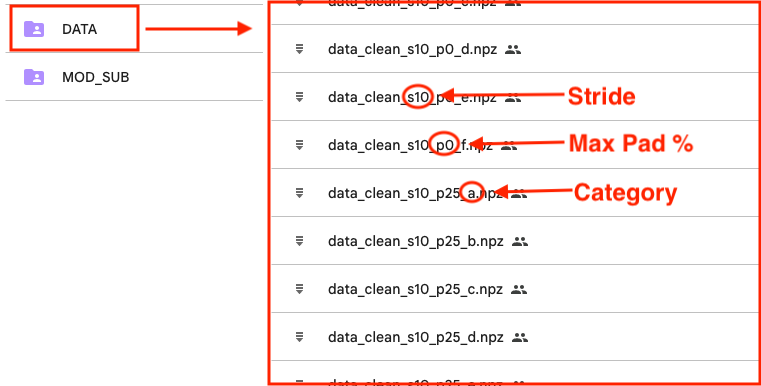

*   *ONE MODEL: If model_one = True -> load all data of each category in one array*
*   *DIFFERENT MODEL FOR EACH CATEGORY: If model_one = False and model_name_load = [] -> load just the data of a specific category*
*   *DIFFERENT MODEL FOR EACH CATEGORY: If model_one = False and model_name_load != [] -> load all data of each category in separated arrays*

\
## **Normalization**

The normalization to improve performance and be more robust to outliers.


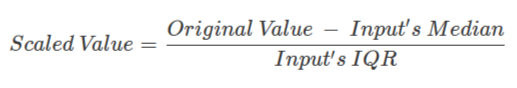



\
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _\
\
*Other resources:*
*   *Normalization (Robust Scaling): https://proclusacademy.com/blog/robust-scaler-outliers/*
*   *Robust Scaling: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler.inverse_transform*

In [ ]:
if model_one: # create just one model for all categories

  model_name_load = []

  # Load all categories
  dataLoad_a = np.load(data_dir+'data_clean_s'+file_stride+'_p'+file_padding+'_'+'a'+'.npz', allow_pickle=True) # shape (x, 200)
  dataLoad_b = np.load(data_dir+'data_clean_s'+file_stride+'_p'+file_padding+'_'+'b'+'.npz', allow_pickle=True)
  dataLoad_c = np.load(data_dir+'data_clean_s'+file_stride+'_p'+file_padding+'_'+'c'+'.npz', allow_pickle=True)
  dataLoad_d= np.load(data_dir+'data_clean_s'+file_stride+'_p'+file_padding+'_'+'d'+'.npz', allow_pickle=True)
  dataLoad_e= np.load(data_dir+'data_clean_s'+file_stride+'_p'+file_padding+'_'+'e'+'.npz', allow_pickle=True)
  dataLoad_f= np.load(data_dir+'data_clean_s'+file_stride+'_p'+file_padding+'_'+'f'+'.npz', allow_pickle=True)
  # append in "data" array all the data of each category
  data = np.delete(np.zeros((1, 200), dtype=float), 0, axis=0) # np.array([[]]) with shape (x, 200) # data = [[]]
  data = np.append(data, dataLoad_a["data"], axis=0) # data = dataLoad_a["data"]
  data = np.append(data, dataLoad_b["data"], axis=0) # data = dataLoad_a["data"] , dataLoad_b["data"]
  data = np.append(data, dataLoad_c["data"], axis=0)
  data = np.append(data, dataLoad_d["data"], axis=0)
  data = np.append(data, dataLoad_e["data"], axis=0)
  data = np.append(data, dataLoad_f["data"], axis=0)
  # append in "out" array all the out of each category
  out = np.delete(np.zeros((1, 18), dtype=float), 0, axis=0) # np.array([[]]) with shape (x, 18)
  out = np.append(out, dataLoad_a["out"], axis=0)
  out = np.append(out, dataLoad_b["out"], axis=0)
  out = np.append(out, dataLoad_c["out"], axis=0)
  out = np.append(out, dataLoad_d["out"], axis=0)
  out = np.append(out, dataLoad_e["out"], axis=0)
  out = np.append(out, dataLoad_f["out"], axis=0)
  # create "strat" as a 1d-array with integers that correspond to each category -> for validation split purpose
  strat = np.array([])
  strat = np.append(strat, np.full(len(dataLoad_a["out"]), 1, dtype=int))
  strat = np.append(strat, np.full(len(dataLoad_b["out"]), 2, dtype=int))
  strat = np.append(strat, np.full(len(dataLoad_c["out"]), 3, dtype=int))
  strat = np.append(strat, np.full(len(dataLoad_d["out"]), 4, dtype=int))
  strat = np.append(strat, np.full(len(dataLoad_e["out"]), 5, dtype=int))
  strat = np.append(strat, np.full(len(dataLoad_f["out"]), 6, dtype=int))
  # Data normalization -> calculating the median and iqr on the data and use them on data and out
  # We choose median and iqr (and not mean and std) to have more robust values to outliers
  median = np.median(data)
  iqr = np.percentile(data, 75) - np.percentile(data, 25)
  if iqr != 0.0:
    data = (data - median) / iqr
    out = (out - median) / iqr
  # Inspect Data & Labels
  print("\n\033[1mData Shape\033[0m:", data.shape)
  print("\033[1mOut Shape\033[0m:", out.shape)
  # Split in train and validation
  data_train, data_val, out_train, out_val = train_test_split(data, out, random_state=seed, test_size=val_size, stratify=strat)

elif len(model_name_load) == 0: # load the data of a particular category
  # Load
  dataLoad = np.load(data_dir+'data_clean_s'+file_stride+'_p'+file_padding+'_'+file_category+'.npz', allow_pickle=True)
  # Store data, labels
  data = dataLoad["data"]
  out = dataLoad["out"]
  # Data normalization
  median = np.median(data)
  iqr = np.percentile(data, 75) - np.percentile(data, 25)
  if iqr != 0.0:
    data = (data - median) / iqr
    out = (out - median) / iqr
  # Inspect Data & Labels
  print("\n\033[1mData Shape\033[0m:", data.shape)
  print("\033[1mOut Shape\033[0m:", out.shape)
  # Split in train and validation -> directly in the fit() method
  data_train = data
  out_train = out

else: # len(model_name_load) > 0 and model_one == False
  # Load the data of each category for merging all models in one
  # A
  arr = model_name_load[0].split('_')
  data_clean_a = np.load(data_dir+'data_clean_'+arr[2]+'_'+arr[3]+'_'+arr[1]+'.npz', allow_pickle=True)
  median_a = np.median(data_clean_a['data'])
  iqr_a = np.percentile(data_clean_a['data'],75) - np.percentile(data_clean_a['data'],25)
  # B
  arr = model_name_load[1].split('_')
  data_clean_b = np.load(data_dir+'data_clean_'+arr[2]+'_'+arr[3]+'_'+arr[1]+'.npz', allow_pickle=True)
  median_b = np.median(data_clean_b['data'])
  iqr_b = np.percentile(data_clean_b['data'],75) - np.percentile(data_clean_b['data'],25)
  # C
  arr = model_name_load[2].split('_')
  data_clean_c = np.load(data_dir+'data_clean_'+arr[2]+'_'+arr[3]+'_'+arr[1]+'.npz', allow_pickle=True)
  median_c = np.median(data_clean_c['data'])
  iqr_c = np.percentile(data_clean_c['data'],75) - np.percentile(data_clean_c['data'],25)
  # D
  arr = model_name_load[3].split('_')
  data_clean_d = np.load(data_dir+'data_clean_'+arr[2]+'_'+arr[3]+'_'+arr[1]+'.npz', allow_pickle=True)
  median_d = np.median(data_clean_d['data'])
  iqr_d = np.percentile(data_clean_d['data'],75) - np.percentile(data_clean_d['data'],25)
  # E
  arr = model_name_load[4].split('_')
  data_clean_e = np.load(data_dir+'data_clean_'+arr[2]+'_'+arr[3]+'_'+arr[1]+'.npz', allow_pickle=True)
  median_e = np.median(data_clean_e['data'])
  iqr_e = np.percentile(data_clean_e['data'],75) - np.percentile(data_clean_e['data'],25)
  # F
  arr = model_name_load[5].split('_')
  data_clean_f = np.load(data_dir+'data_clean_'+arr[2]+'_'+arr[3]+'_'+arr[1]+'.npz', allow_pickle=True)
  median_f = np.median(data_clean_f['data'])
  iqr_f = np.percentile(data_clean_f['data'],75) - np.percentile(data_clean_f['data'],25)



Data Shape: (18255, 200)
Out Shape: (18255, 18)


---
# 🤖 **CREATE / MERGE MODEL** 🤖

* *Create Attention layer (as a child class of Keras Layer class)*
* *Create all other layers (Conv1D, Dense, Resblock, Resblock_LSTM, LSTM, ...)*
* *Generate a unique model name with a counter file*
* *Create model*
 *  *One model for all categories*
 *  *One model for each categories*
 *  *One model that merges all models of each categories*

\
## **Attention Layer**

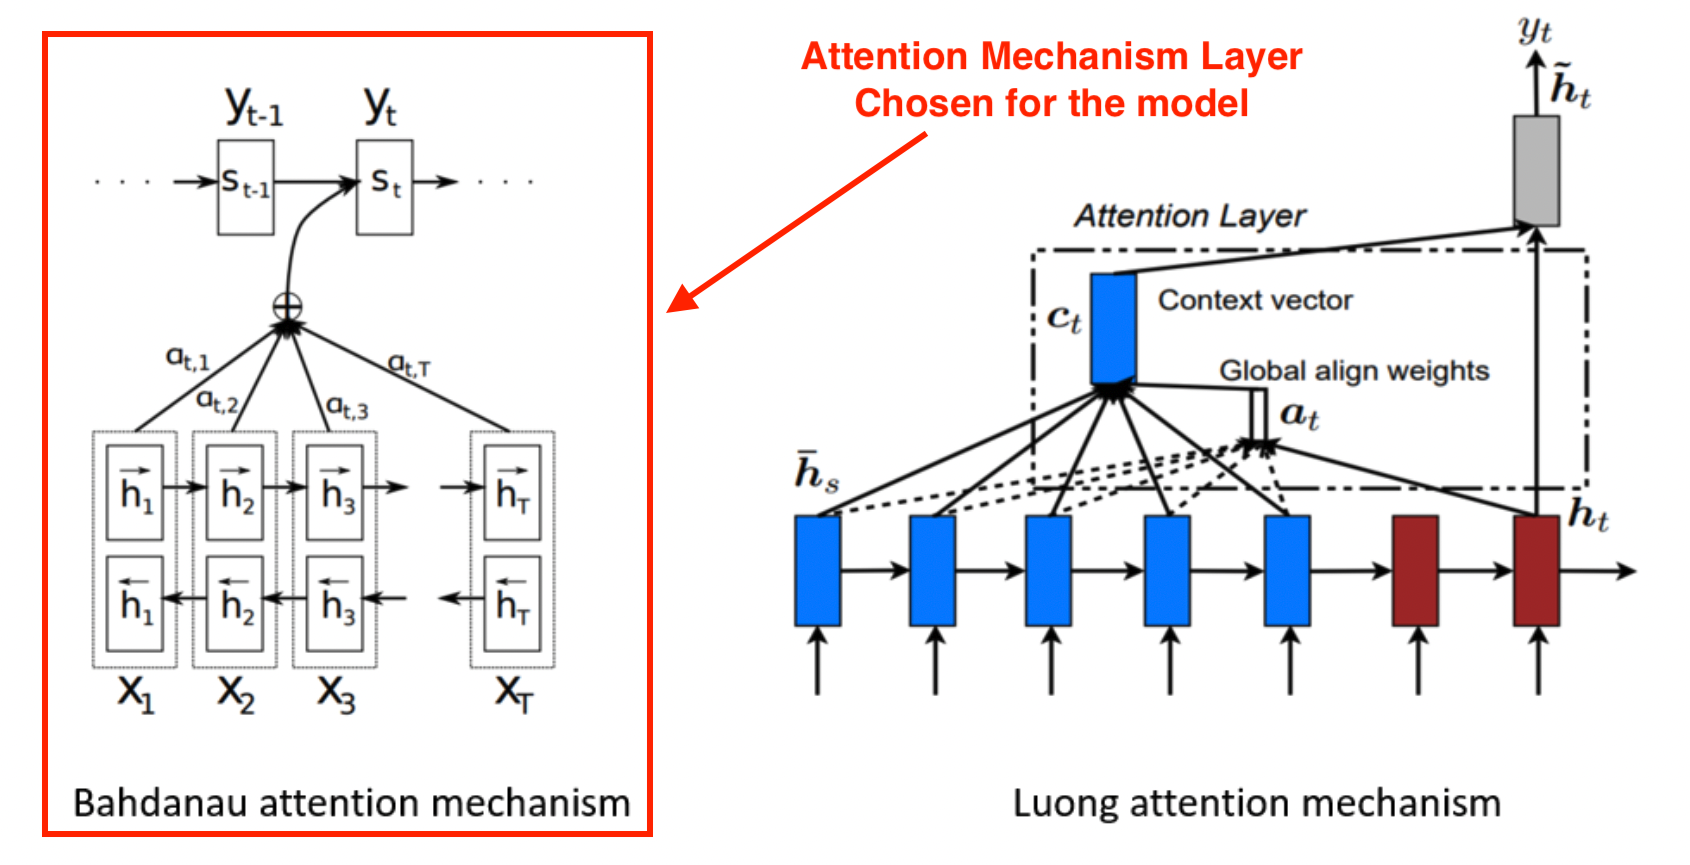

\
## **Resblock & Resblock_LSTM**

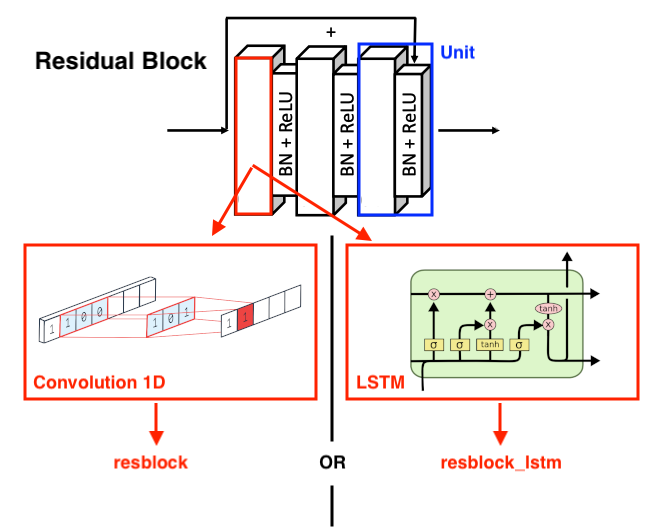

\


## **Merge Models**

/

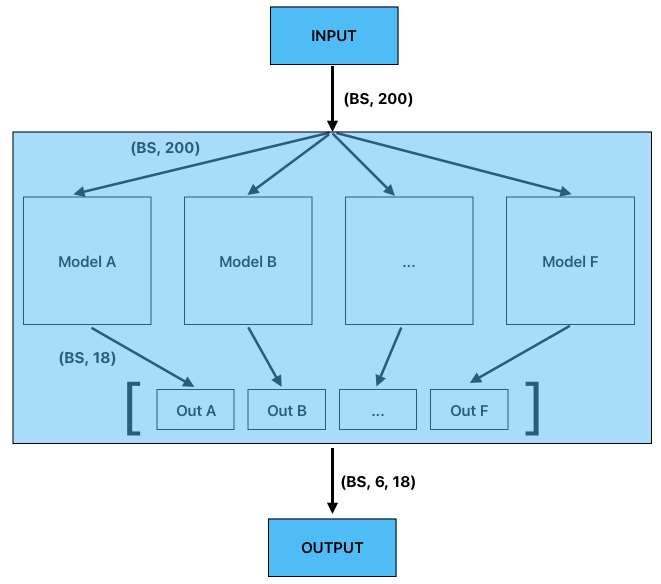


\
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _\
\
*Other resources:*
* *Create a Keras Layer from scratch : https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/*
*   *Attention from scratch : https://machinelearningmastery.com/the-attention-mechanism-from-scratch/*
*   *Attention Keras Layer : https://keras.io/api/layers/attention_layers/attention/*
*   *Attention Tensorflow Layer : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention*
*   *ResNet : https://arxiv.org/abs/1512.03385*
*   *ResNet : https://arxiv.org/pdf/1611.06455.pdf*

* *Merge models : https://stackoverflow.com/questions/63284471/tensorflow-use-model-inside-another-model-as-layer*

*   *Other on timeseries forecasting architectures:*
 * *https://keras.io/examples/timeseries/*
 * *https://keras.io/examples/timeseries/timeseries_traffic_forecasting/*
 * *https://keras.io/examples/timeseries/timeseries_weather_forecasting/*
 * *https://www.tensorflow.org/tutorials/structured_data/time_series?hl=it*
 * *https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/*
 * *https://www.ikigailabs.io/blog/how-to-choose-the-best-model-for-time-series-forecasting-arima-prophet-or-mssa*

In [ ]:
if model_one:
  file_category = 'ALL'

if model_one or len(model_name_load) == 0:

  # New class derived from Keras Layer to implement Attention
  class attention(tfkl.Layer): # as described in the picture
      def __init__(self,**kwargs):
          super(attention,self).__init__(**kwargs)

      def build(self,input_shape):
          # Weights start with normal initialization as usual
          # Bias starts from zero
          self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                                initializer='random_normal', trainable=True)
          self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                                initializer='zeros', trainable=True)
          super(attention, self).build(input_shape)

      def call(self,x):
          # Alignment scores. Pass them through tanh function (we are using Bahdanau attention)
          e = tfkb.tanh(tfkb.dot(x,self.W)+self.b)
          # Remove dimension of size 1
          e = tfkb.squeeze(e, axis=-1)
          # Compute the weights
          alpha = tfkb.softmax(e)
          # Reshape to tensorFlow format
          alpha = tfkb.expand_dims(alpha, axis=-1)
          # Compute the context vector
          context = x * alpha
          context = tfkb.sum(context, axis=1)
          context = tf.expand_dims(context, axis=-1)
          return context

  # Generate unique name for the model & submission (ex. model_name = "m123", submission_name = "s123")
  f = open(modsub_dir+"count.txt", "r")
  count = f.read()
  next = int(count) + 1
  count = str(count)
  f.close()
  f = open(modsub_dir+"count.txt", "w")
  f.write(str(next))
  f.close()
  model_name = 'm'+count+'_'+file_category+'_s'+file_stride+'_p'+file_padding
  submission_name = 's'+count

  # Data Shape (input shape for the model) & Labels Shape (output for the model)
  data_shape = (data.shape[1], 1) # data.shape[1:]
  out_shape = int(out.shape[1])

  # Fix randomness
  tf.random.set_seed(seed)

  # Input Layer
  input_layer = tfkl.Input(shape=data_shape, name='IN')

  hidden_layer = input_layer


  i = 1
  for l in layer:
    if l["type"] == "conv1d":
      hidden_layer = tfkl.Conv1D(filters=l["filters"], kernel_size=l["kernel"], padding='same', activation=l["activation"], name=str(i)+'_CONV1D_'+l["activation"])(hidden_layer)
      i = i+1
    elif l["type"] == "conv2d":
      hidden_layer = tfkl.Conv2D(filters=l["filters"], kernel_size=l["kernel"], padding='same', activation=l["activation"], name=str(i)+'_CONV2D_'+l["activation"])(hidden_layer)
      i = i+1
    elif l["type"] == "maxp":
      hidden_layer = tfkl.MaxPooling2D(pool_size=l["kernel"], name=str(i)+'_MAXP')(hidden_layer)
      i = i+1
    elif l["type"] == "dense":
      hidden_layer = tfkl.Dense(units=l["units"], activation=l["activation"], name=str(i)+'_DENSE_'+l["activation"])(hidden_layer)
      i = i+1
    elif l["type"] == "gap":
      hidden_layer = tfkl.GlobalAveragePooling2D(name=str(i)+'_GAP')(hidden_layer)
      i = i+1
    elif l["type"] == "dropout":
      hidden_layer = tfkl.Dropout(l["rate"], name=str(i)+'_DROPOUT_'+str(l["rate"]))(hidden_layer)
      i = i+1
    elif l["type"] == "flat":
      hidden_layer = tfkl.Flatten(name=str(i)+'_FLAT')(hidden_layer)
      i = i+1
    elif l["type"] == "lstm":
      if l["bidirectional"]:
        hidden_layer = tfkl.Bidirectional(tfkl.LSTM(l["units"], return_sequences=l["return_sequences"], name=str(i)+'_LSTM'), name=str(i)+'_BiLSTM')(hidden_layer)
      else:
        hidden_layer = tfkl.LSTM(l["units"], return_sequences=l["return_sequences"], name=str(i)+'_LSTM')(hidden_layer)
      i = i+1
    elif l["type"] == "crop1d":
      hidden_layer = tfkl.Cropping1D((0, hidden_layer.shape[1] - l["outsize"]), name=str(i)+'_CROP1D')(hidden_layer)
      i = i+1
    elif l["type"] == "resblock": # as described in the picture
      hidden_layer = tfkl.MaxPooling1D(name=str(i) + '_RB_MAXPOOL')(hidden_layer)
      hidden_layer_ = hidden_layer
      for s in range(l["units"]):
        hidden_layer_ = tfkl.Conv1D(filters=l["filters"], kernel_size=l["kernel"], padding="same", name= str(i) + '_'+str(s)+ '_RB_CONV1D_' + str(l["filters"]) + "_" + str(l["kernel"]))(hidden_layer_)
        hidden_layer_ = tfkl.BatchNormalization(name=str(i) + '_'+str(s)+ '_RB_BATCHNORM')(hidden_layer_)
        hidden_layer_ = tfkl.Activation(l["activation"], name=str(i) + '_'+str(s)+ '_RB_ACTIVATION_' + l["activation"])(hidden_layer_)
      hidden_layer = tfkl.Conv1D(filters=l["filters"], kernel_size=1, padding='same', name=str(i) + '_RB_CONV2D')(hidden_layer)
      hidden_layer = tfkl.Add(name=str(i) + "_RB_ADD")([hidden_layer_, hidden_layer])
      i = i + 1
    elif l["type"] == "resblock_lstm": # as described in the picture
      hidden_layer = tfkl.MaxPooling1D(name=str(i) + '_RB_MAXPOOL')(hidden_layer)
      hidden_layer_ = hidden_layer
      for s in range(l["units"]):
        if l["bidirectional"]:
          hidden_layer_ = tfkl.Bidirectional(tfkl.LSTM(l["lstm_units"], return_sequences= True, name= str(i) + '_'+ str(s) + '_RB_LSTM_' + str(l["lstm_units"])), name=str(i)+ '_' + str(s) + '_RB_BiLSTM')(hidden_layer_)
        else:
          hidden_layer_ = tfkl.LSTM(l["lstm_units"], return_sequences= True, name= str(i) + '_'+ str(s) + '_RB_LSTM_' + str(l["lstm_units"]))(hidden_layer_)
        hidden_layer_ = tfkl.BatchNormalization(name=str(i) + '_'+str(s)+ '_RB_BATCHNORM')(hidden_layer_)
        hidden_layer_ = tfkl.Activation(l["activation"], name=str(i) + '_'+str(s)+ '_RB_ACTIVATION_' + l["activation"])(hidden_layer_)
      if l["bidirectional"]:
        hidden_layer = tfkl.Conv1D(filters=2 * int(l["lstm_units"]), kernel_size=1, padding='same', name=str(i) + '_RB_CONV2D')(hidden_layer)
      else:
        hidden_layer = tfkl.Conv1D(filters=l["lstm_units"], kernel_size=1, padding='same', name=str(i) + '_RB_CONV2D')(hidden_layer)
      hidden_layer = tfkl.Add(name=str(i) + "_RB_ADD")([hidden_layer_, hidden_layer])
      i = i + 1
    elif l["type"] == "attention":
      hidden_layer = attention(name = str(i) + "_ATTENTION")(hidden_layer)
      i = i + 1
    elif l["type"] == "xception":
      h = tfk.applications.Xception(name = str(i)+'_XCEPTION_trainableFalse', include_top = False, weights = "imagenet", input_shape = data_shape, classifier_activation = "softmax") # Load the Xception Net for transfer learning (include_top = False : whether to include the fully-connected layer at the top of the network)
      h.trainable = False # We want to do Transfer learning, so we freeze the weights of the Feature Extraction Network
      i = i+1
      hidden_layer = h(tfkl.Rescaling(scale=1 / 127.5, offset=-1, name = str(i)+'_XCEPTION_Rescaling')(hidden_layer)) # Normalize
      i = i+1
    elif l["type"] == "efficientnetb4":
      h = tfk.applications.EfficientNetB4(name = str(i)+'_EFFICIENTNETB4_trainableFalse', include_top = False, weights = "imagenet", input_shape = data_shape, input_tensor = None, pooling = None) # Load the EfficientNetB4 for transfer learning (include_top = False : whether to include the fully-connected layer at the top of the network).
      h.trainable = False # We want to do Transfer learning, so we freeze the weights of the Feature Extraction Network
      hidden_layer = h(hidden_layer)
      i = i+1
    elif l["type"] == "efficientnetv2s":
      h = tfk.applications.EfficientNetV2S(name = str(i)+'_EFFICIENTNETV2S_trainableFalse', include_top = False, weights = "imagenet", input_shape = data_shape, input_tensor = None, pooling = None, include_preprocessing = True) # Load the EfficientNetV2S for transfer learning (include_top = False : whether to include the fully-connected layer at the top of the network) (include_preprocessing = True : specify we want to include the preprocessing part, so the network will normalize data by itself).
      h.trainable = False # We want to do Transfer learning, so we freeze the weights of the Feature Extraction Network
      hidden_layer = h(hidden_layer)
      i = i+1

  # Output Layer
  output_layer = tfkl.Conv1D(1, 3, padding='same', name='OUT_PRECROPPED')(hidden_layer)                        # Add a final Convolution layer to match the desired output shape
  output_layer = tfkl.Cropping1D((0,  output_layer.shape[1] - out_shape ), name='OUT')(output_layer)           # Crop the output to the desired length


  # Build Model
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name=model_name)

  # Compile Model
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate))

  # Inspect Model
  model.summary()

else:

  # Generate unique name for the model & submission (ex. model_name = "m123", submission_name = "s123")
  f = open(modsub_dir+"count.txt", "r")
  count = f.read()
  next = int(count) + 1
  count = str(count)
  f.close()
  f = open(modsub_dir+"count.txt", "w")
  f.write(str(next))
  f.close()
  model_name = 'm'+count
  submission_name = 's'+count

  # Load all models of each category
  model_a = tf.keras.models.load_model(modsub_dir+model_name_load[0])
  model_b = tf.keras.models.load_model(modsub_dir+model_name_load[1])
  model_c = tf.keras.models.load_model(modsub_dir+model_name_load[2])
  model_d = tf.keras.models.load_model(modsub_dir+model_name_load[3])
  model_e = tf.keras.models.load_model(modsub_dir+model_name_load[4])
  model_f = tf.keras.models.load_model(modsub_dir+model_name_load[5])

  # Merge models
  input_layer = tfkl.Input(shape=(200,1), name='IN')
  output_layer_a = model_a(input_layer)
  output_layer_b = model_b(input_layer)
  output_layer_c = model_c(input_layer)
  output_layer_d = model_d(input_layer)
  output_layer_e = model_e(input_layer)
  output_layer_f = model_f(input_layer)
  output_layer = [output_layer_a, output_layer_b, output_layer_c, output_layer_d, output_layer_e, output_layer_f]

  # Build Model
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name=model_name)

  # Compile Model
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate))

  # Inspect Model
  model.summary()
  #tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "m100_c_s75_p50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IN (InputLayer)             [(None, 200, 1)]          0         
                                                                 
 1_BiLSTM (Bidirectional)    (None, 200, 256)          133120    
                                                                 
 attention (attention)       (None, 256, 1)            456       
                                                                 
 3_DENSE_relu (Dense)        (None, 256, 128)          256       
                                                                 
 OUT_PRECROPPED (Conv1D)     (None, 256, 1)            385       
                                                                 
 OUT (Cropping1D)            (None, 18, 1)             0         
                                                                 
Total params: 134217 (524.29 KB)
Trainable params: 1

---
# 🏋🏻 **TRAIN MODEL [PHASE]** 🏋🏻

*   *Train the model*
*   *Plot the model*

In [ ]:
if train_phase:

  if model_one:
    # Train the model
    model_history = model.fit(
      x = data_train,
      y = out_train,
      batch_size = batch_size,
      epochs = epochs,
      #validation_split = val_size,
      validation_data = (data_val, out_val),
      #use_multiprocessing = True,
      #verbose = 0,
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=earlystopping_patience, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=plateaustopping_patience, factor=0.1, min_lr=1e-5)]

    ).history

  elif len(model_name_load) == 0:
    # Train the model
    model_history = model.fit(
      x = data_train,
      y = out_train,
      batch_size = batch_size,
      epochs = epochs,
      validation_split = val_size,
      #validation_data=(data_val, out_val),
      #use_multiprocessing = True,
      #verbose = 0,
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=earlystopping_patience, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=plateaustopping_patience, factor=0.1, min_lr=1e-5)]

    ).history

  if model_one or len(model_name_load) == 0:
    # Training Loss & Validation Loss
    plt.figure(figsize=(15,4))
    plt.plot(model_history['loss'], label='Training Loss', alpha=.8, color='#ff7f0e')
    plt.plot(model_history['val_loss'], label='Validation Loss', alpha=.8, color='#0e76ff')
    plt.title('Loss')
    plt.legend()
    plt.grid(alpha=.3)
    # Plot
    plt.show()

Epoch 1/400
257/257 [==============================] - 18s 25ms/step - loss: 0.1933 - val_loss: 0.1551 - lr: 0.0010
Epoch 2/400
257/257 [==============================] - 6s 25ms/step - loss: 0.1447 - val_loss: 0.1382 - lr: 0.0010
Epoch 3/400
257/257 [==============================] - 6s 23ms/step - loss: 0.1119 - val_loss: 0.1283 - lr: 0.0010
Epoch 4/400
257/257 [==============================] - 7s 28ms/step - loss: 0.1490 - val_loss: 0.1279 - lr: 0.0010
Epoch 5/400
257/257 [==============================] - 6s 22ms/step - loss: 0.1490 - val_loss: 0.1859 - lr: 0.0010
Epoch 6/400
257/257 [==============================] - 5s 21ms/step - loss: 0.1657 - val_loss: 0.1649 - lr: 0.0010
Epoch 7/400
257/257 [==============================] - 6s 24ms/step - loss: 0.1248 - val_loss: 0.1291 - lr: 0.0010
Epoch 8/400
257/257 [==============================] - 5s 21ms/step - loss: 0.0845 - val_loss: 0.0887 - lr: 0.0010
Epoch 9/400
257/257 [==============================] - 6s 22ms/step - loss: 0.0

---
# 🕵🏻 **INFERENCE MODEL** 🕵🏻

*   *Make inference on the model*
*   *Calculate and print Mean Squared Error (MSE)*
*   *Calculate and print Mean Absolute Error (MAE)*

In [ ]:
# Make inference on the model
predictions = model.predict(data_train, verbose=0)

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(out_train.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(out_train.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")


Mean Squared Error: 0.04199480265378952
Mean Absolute Error: 0.1406988799571991


---
# 💾 **SAVE & DELETE MODEL** 💾

*   *Save Model Keras files (directory)*
*   *Submission (directory)*
*   *Delete Model*

\
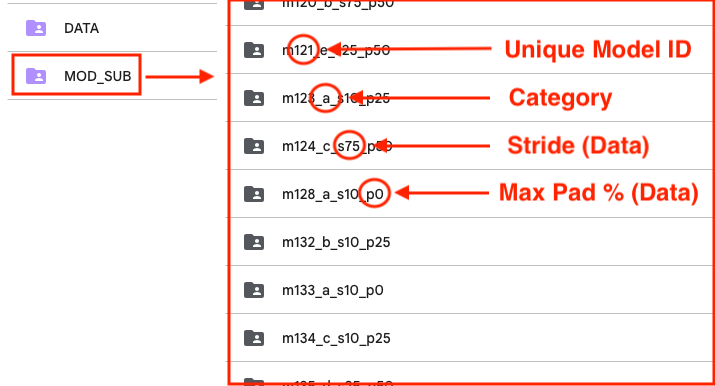



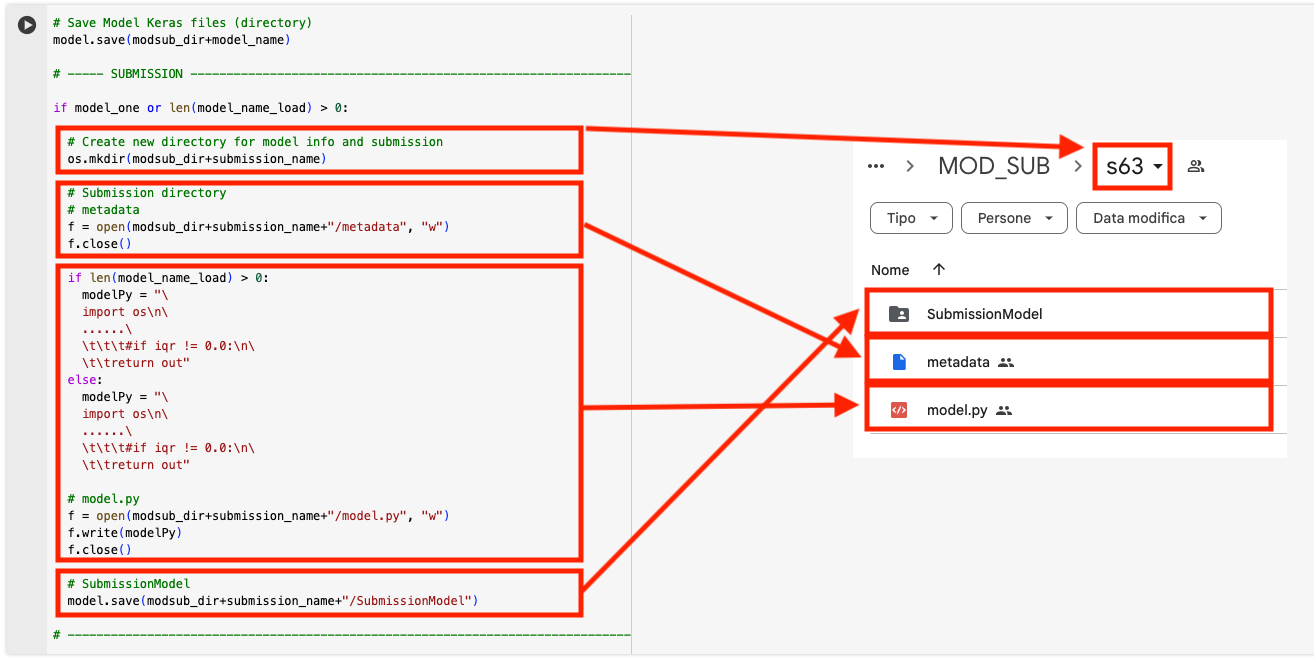)


\
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _\
\
*Other resources:*
*   *File: https://www.geeksforgeeks.org/file-handling-python/*

In [ ]:
# Save Model Keras files (directory)
model.save(modsub_dir+model_name)

# ----- SUBMISSION -------------------------------------------------------------

if model_one or len(model_name_load) > 0:

  # Create new directory for model info and submission
  os.mkdir(modsub_dir+submission_name)

  # Submission directory
  # metadata
  f = open(modsub_dir+submission_name+"/metadata", "w")
  f.close()

  if len(model_name_load) > 0:
    modelPy = "import os\nimport tensorflow as tf\nimport numpy as np\nclass model:\n\tdef __init__(self, path):\n\t\tself.mod = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))\n\t\t#self.mod was initially self.model\n\tdef predict(self, X, index_category):\n\t\tout_dim="+str(test_out_dim)+"\n\t\tmedian_a="+str(median_a)+"\n\t\tmedian_b="+str(median_b)+"\n\t\tmedian_c="+str(median_c)+"\n\t\tmedian_d="+str(median_d)+"\n\t\tmedian_e="+str(median_e)+"\n\t\tmedian_f="+str(median_f)+"\n\t\tiqr_a="+str(iqr_a)+"\n\t\tiqr_b="+str(iqr_b)+"\n\t\tiqr_c="+str(iqr_c)+"\n\t\tiqr_d="+str(iqr_d)+"\n\t\tiqr_e="+str(iqr_e)+"\n\t\tiqr_f="+str(iqr_f)+"\n\t\tout=np.zeros((X.shape[0],out_dim))\n\t\tfor i in range(X.shape[0]):\n\t\t\t#median = np.median(X[i])\n\t\t\t#iqr = np.percentile(X[i], 75) - np.percentile(X[i], 25)\n\t\t\t#if iqr!= 0.0:\n\t\t\tif index_category[i]=='A':\n\t\t\t\t#se considero tutta la riga\n\t\t\t\tX[i] = (X[i] - median_a) / iqr_a\n\t\t\t\toutTot = self.mod.predict(X[i][np.newaxis, ...])\n\t\t\t\tout[i] = outTot[0][0].flatten()[:out_dim]\n\t\t\t\tout[i] = (out[i]*iqr_a) + median_a\n\t\t\telif  index_category[i]=='B':\n\t\t\t\tX[i] = (X[i] - median_b) / iqr_b\n\t\t\t\toutTot = self.mod.predict(X[i][np.newaxis, ...])\n\t\t\t\tout[i] = outTot[1][0].flatten()[:out_dim]\n\t\t\t\tout[i] = (out[i]*iqr_b) + median_b\n\t\t\telif index_category[i]=='C':\n\t\t\t\tX[i] = (X[i] - median_c) / iqr_c\n\t\t\t\toutTot = self.mod.predict(X[i][np.newaxis, ...])\n\t\t\t\tout[i] = outTot[2][0].flatten()[:out_dim]\n\t\t\t\tout[i] = (out[i]*iqr_c) + median_c\n\t\t\telif index_category[i]=='D':\n\t\t\t\tX[i] = (X[i] - median_d) / iqr_d\n\t\t\t\toutTot = self.mod.predict(X[i][np.newaxis, ...])\n\t\t\t\tout[i] = outTot[3][0].flatten()[:out_dim]\n\t\t\t\tout[i] = (out[i]*iqr_d) + median_d\n\t\t\telif index_category[i]=='E':\n\t\t\t\tX[i] = (X[i] - median_e) / iqr_e\n\t\t\t\toutTot = self.mod.predict(X[i][np.newaxis, ...])\n\t\t\t\tout[i] = outTot[4][0].flatten()[:out_dim]\n\t\t\t\tout[i] = (out[i]*iqr_e) + median_e\n\t\t\telif index_category[i]=='F':\n\t\t\t\tX[i] = (X[i] - median_f) / iqr_f\n\t\t\t\toutTot = self.mod.predict(X[i][np.newaxis, ...])\n\t\t\t\tout[i] = outTot[5][0].flatten()[:out_dim]\n\t\t\t\tout[i] = (out[i]*iqr_f) + median_f\n\t\t\t#if iqr != 0.0:\n\t\treturn out"
  else:
    modelPy = "import os\nimport tensorflow as tf\nimport numpy as np\nclass model:\n\tdef __init__(self, path):\n\t\tself.mod = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))\n\tdef predict(self, X, index_category):\n\t\tout_dim="+str(test_out_dim)+"\n\t\tmedian="+str(median)+"\n\t\tiqr="+str(iqr)+"\n\t\tout=np.zeros((X.shape[0],out_dim))\n\t\tfor i in range(X.shape[0]):\n\t\t\t\tX[i] = (X[i] - median) / iqr\n\t\t\t\toutTot = self.mod.predict(X[i][np.newaxis, ...])\n\t\t\t\tout[i] = outTot[0].flatten()[:out_dim]\n\t\t\t\tout[i] = (out[i]*iqr) + median\n\t\treturn out"

  # model.py
  f = open(modsub_dir+submission_name+"/model.py", "w")
  f.write(modelPy)
  f.close()

  # SubmissionModel
  model.save(modsub_dir+submission_name+"/SubmissionModel")

# ------------------------------------------------------------------------------


# Delete Model
del model

if len(model_name_load) > 0:
  # Delete intermediated models
  del model_a
  del model_b
  del model_c
  del model_d
  del model_e
  del model_f

---

# **FINAL BEST MODEL - PHASE 2**

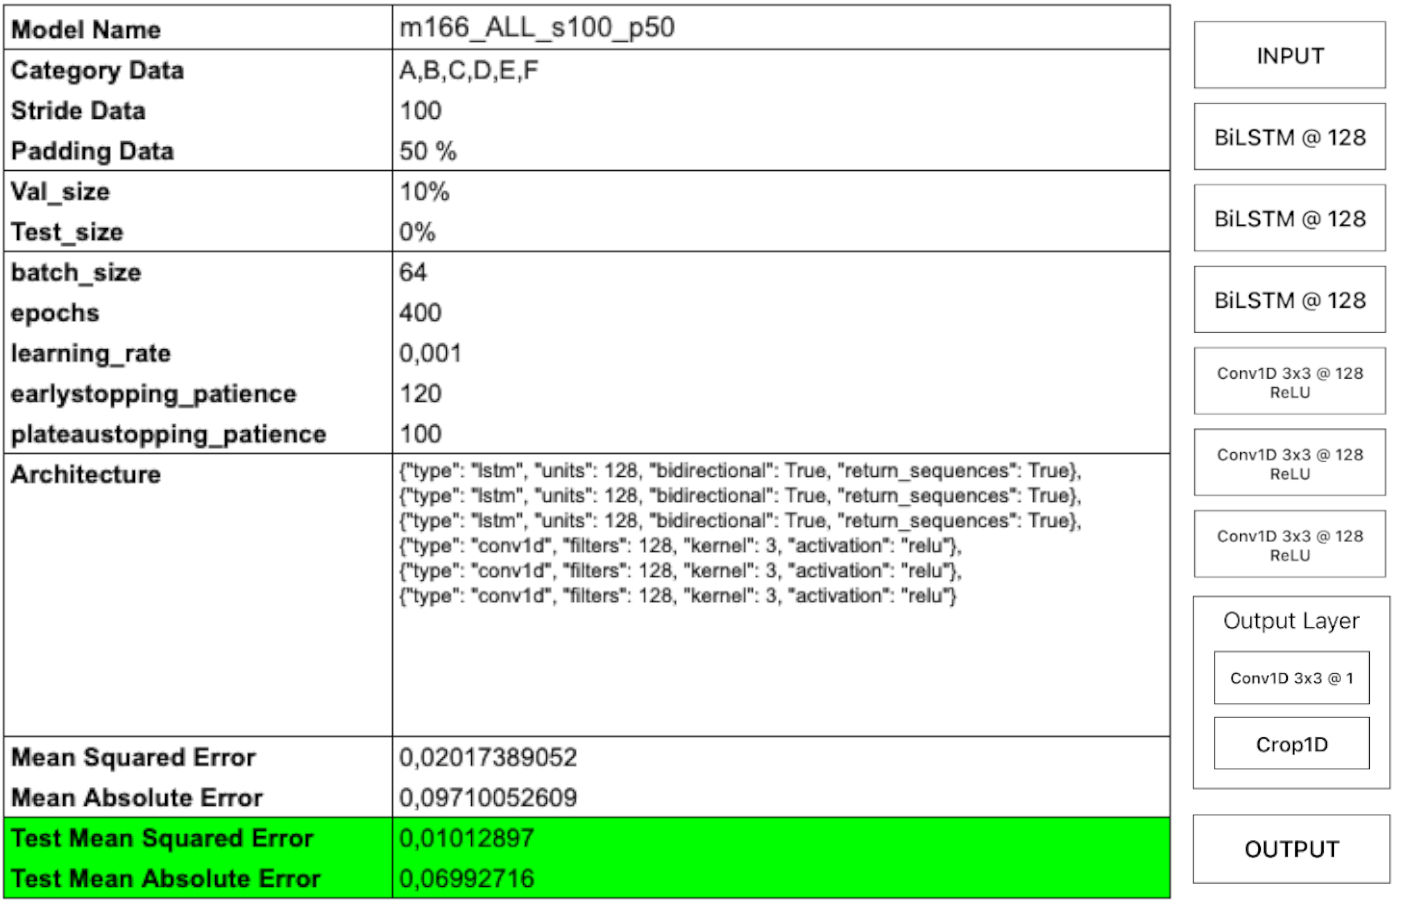

---
# **FINAL BEST MODEL - PHASE 1**



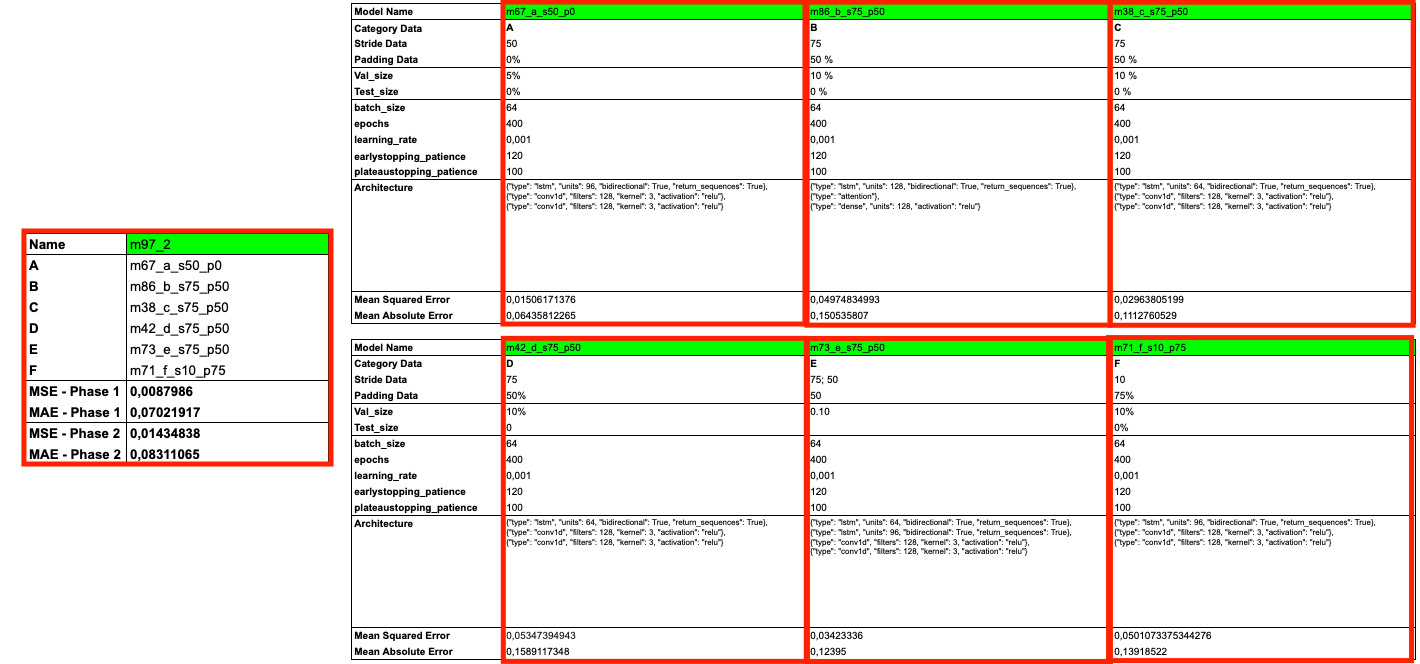


\

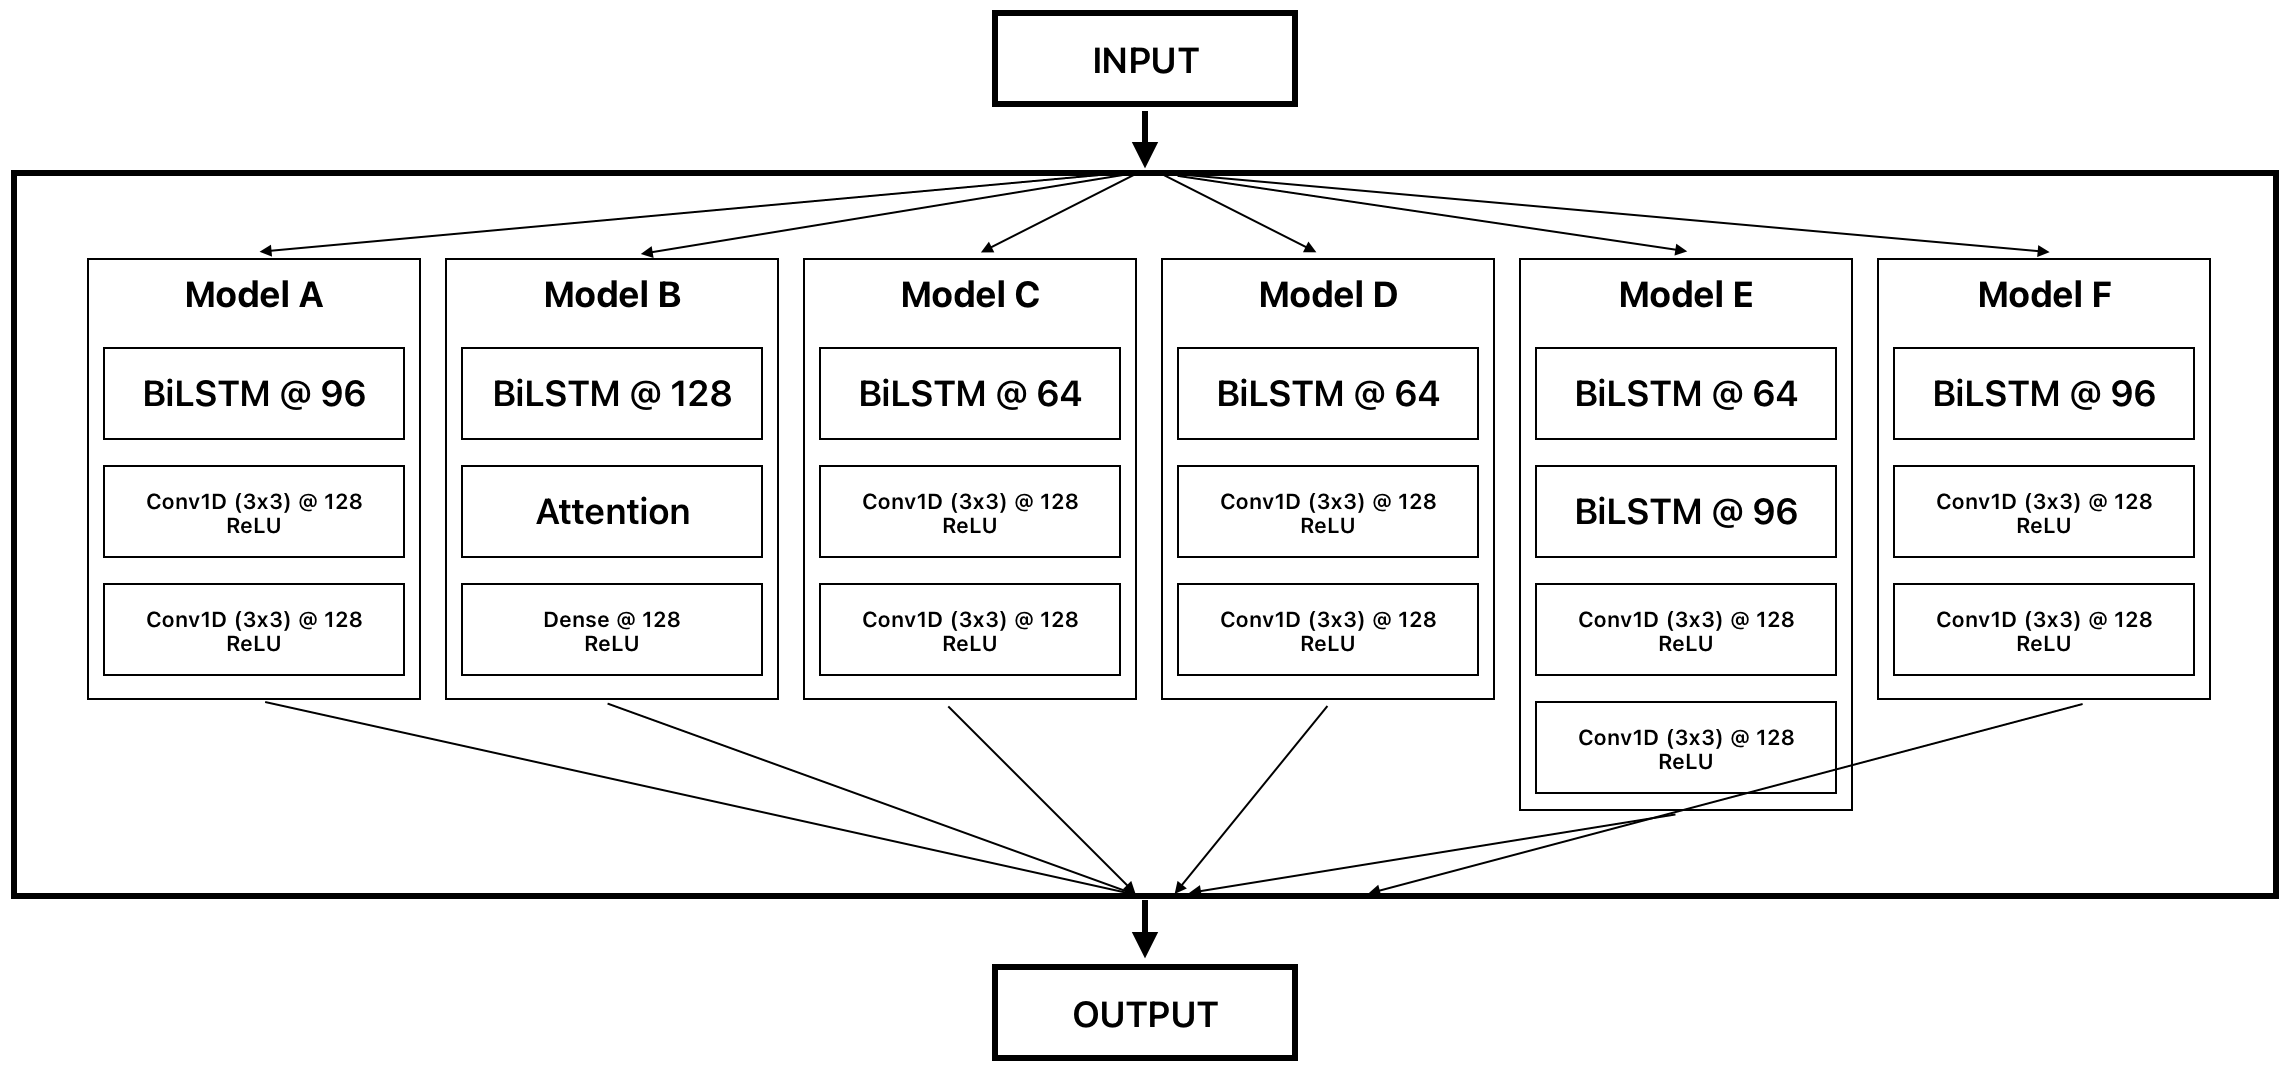


